In [298]:
import sys

sys.path.append("../../../")
import random
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.linalg import eigh
from scipy.stats import beta
from tqdm import tqdm

from lcs import *

random.seed(1234)


def calc_entropy(mat, normalized=True):
    c_1d = mat.ravel()  # turn into 1d distribution
    p_1d = c_1d / np.sum(c_1d)  # normalize the distribution
    # p_1d = c_1d #do not normalize
    p_1d_masked = p_1d[p_1d > 0]  # remove the zeros
    entropy = -np.sum(p_1d_masked * np.log2(p_1d_masked))  # calculate the entropy
    if normalized == True:
        return entropy
    else:
        return entropy * mat.sum()


def degree_infection_hist(my_A, my_c_i):
    degree_mat = my_A.sum(axis=1)
    max_degree = degree_mat.max()
    degree_df = pd.DataFrame(degree_mat, columns=["degree"])

    ci_df = pd.DataFrame(my_c_i)
    ci_degree = degree_df.join(ci_df)
    # max column
    max_col = my_c_i[my_c_i.any(axis=0)].shape[0]

    # ci_degree.set_index_degree = ci_degree.set_index('degree')
    ci_degree.sort_index(inplace=True)
    ci_degree_hist = ci_degree.groupby("degree").sum()
    ci_degree_hist_cut = ci_degree_hist.iloc[:, :max_col]
    ci_degree_hist_cut.sort_values(by="degree", ascending=False, inplace=True)
    ci_degree_hist_mat = ci_degree_hist_cut.to_numpy()
    degree_list = ci_degree_hist_cut.index.to_numpy()
    infection_count = ci_degree_hist_cut.columns.values

    return ci_degree_hist_mat, degree_list, infection_count

In [10]:
def a_prime(f, a, b):
    return (f + a + b - 1) / (f * (b / a + 1))


def b_prime(a, b, a_prime):
    return b * a_prime / a

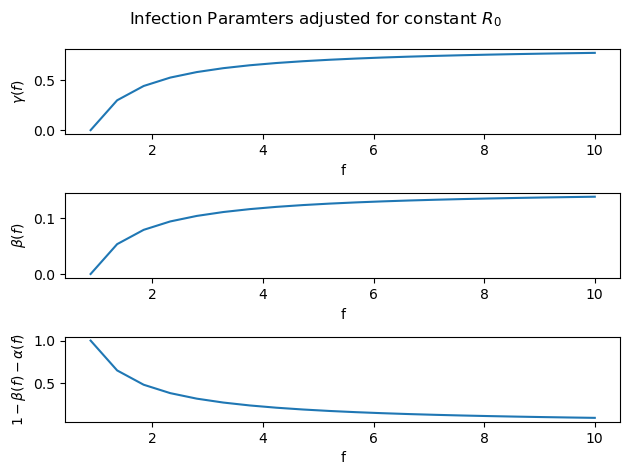

In [11]:
# x0 = np.zeros(n)
# x0[random.randrange(n)] = 1


gamma0 = 0.1
nu = eigh(A)[0][-1]
b0 = 2 * gamma0 / nu
# b0 = 0.1

f_range = np.linspace(1 - b0 - gamma0, 10, 20)  # the range of spreading rates
gamma_range = a_prime(f_range, gamma0, b0)  # generate the corresponding recovery rates
b_range = b_prime(
    gamma0, b0, gamma_range
)  # generate the corresponding transmission rates


fig, ax = plt.subplots(nrows=3)
ax[0].plot(f_range, gamma_range)
ax[0].set(xlabel="f", ylabel="$\gamma(f)$")

ax[1].plot(f_range, b_range)
ax[1].set(xlabel="f", ylabel=r"$\beta(f)$")

ax[2].plot(f_range, 1 - gamma_range - b_range)
ax[2].set(xlabel="f", ylabel=r"$1- \beta(f) - \alpha(f)$")

plt.suptitle("Infection Paramters adjusted for constant $R_0$")
plt.tight_layout()

In [104]:
# simple contagion
random.seed(1243)

nsamples = 20000

G = nx.barabasi_albert_graph(100, 4)
A = nx.adjacency_matrix(G, weight=None).todense()
n = np.size(A, axis=0)

x0 = np.ones(n)
sc = lambda nu, b: 1 - (1 - b) ** nu
c = sc(np.arange(n), b0)

x = contagion_process(A, gamma0, c, x0, tmin=0, tmax=100)

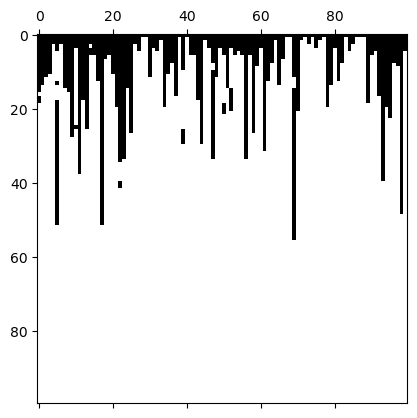

In [105]:
plt.spy(x)

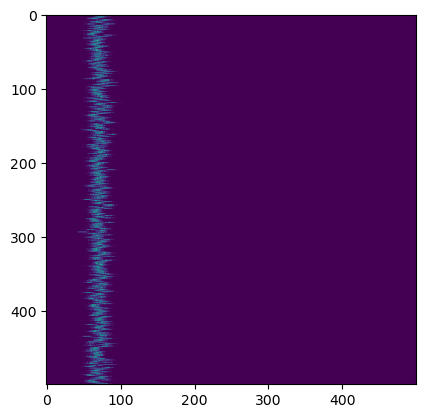

In [106]:
plt.imshow(c_i)

In [108]:
gamma0 = 0.1
nu = eigh(A)[0][-1]
b0 = 2 * gamma0 / nu
# b0 = 0.1

f_range = np.linspace(1 - b0 - gamma0, 10, 20)  # the range of spreading rates
gamma_range = a_prime(f_range, gamma0, b0)  # generate the corresponding recovery rates
b_range = b_prime(
    gamma0, b0, gamma_range
)  # generate the corresponding transmission rates


x_list = []
c_list = []
n_iter = 100
entropy_res = np.zeros((len(f_range), n_iter))
entropy_no_norm_res = np.zeros((len(f_range), n_iter))

for i, f in enumerate(f_range):
    print(i)
    for j in range(n_iter):
        gamma_i = gamma_range[i]
        b_i = b_range[i]
        sc = lambda nu, b: 1 - (1 - b) ** nu
        c = sc(np.arange(n), b_i)
        x = contagion_process(A, gamma_i, c, x0, tmin=0, tmax=100)
        # x_list.append(x)
        c_i, nu_i = count_all_infection_events(x, A)
        # c_list.append(c_i)
        entropy_res[i, j] = calc_entropy(c_i)
        entropy_no_norm_res[i, j] = calc_entropy(c_i, normalized=False)

0


/var/folders/d8/_nh0kys17c383rmrhqbdm9y00000gn/T/ipykernel_85933/1265461989.py:21: RuntimeWarning: invalid value encountered in divide
  p_1d = c_1d / np.sum(c_1d)#normalize the distribution


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


/Users/willthompson/miniconda3/envs/complex_inference/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/willthompson/miniconda3/envs/complex_inference/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/willthompson/miniconda3/envs/complex_inference/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/willthompson/miniconda3/envs/complex_inference/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: Fut

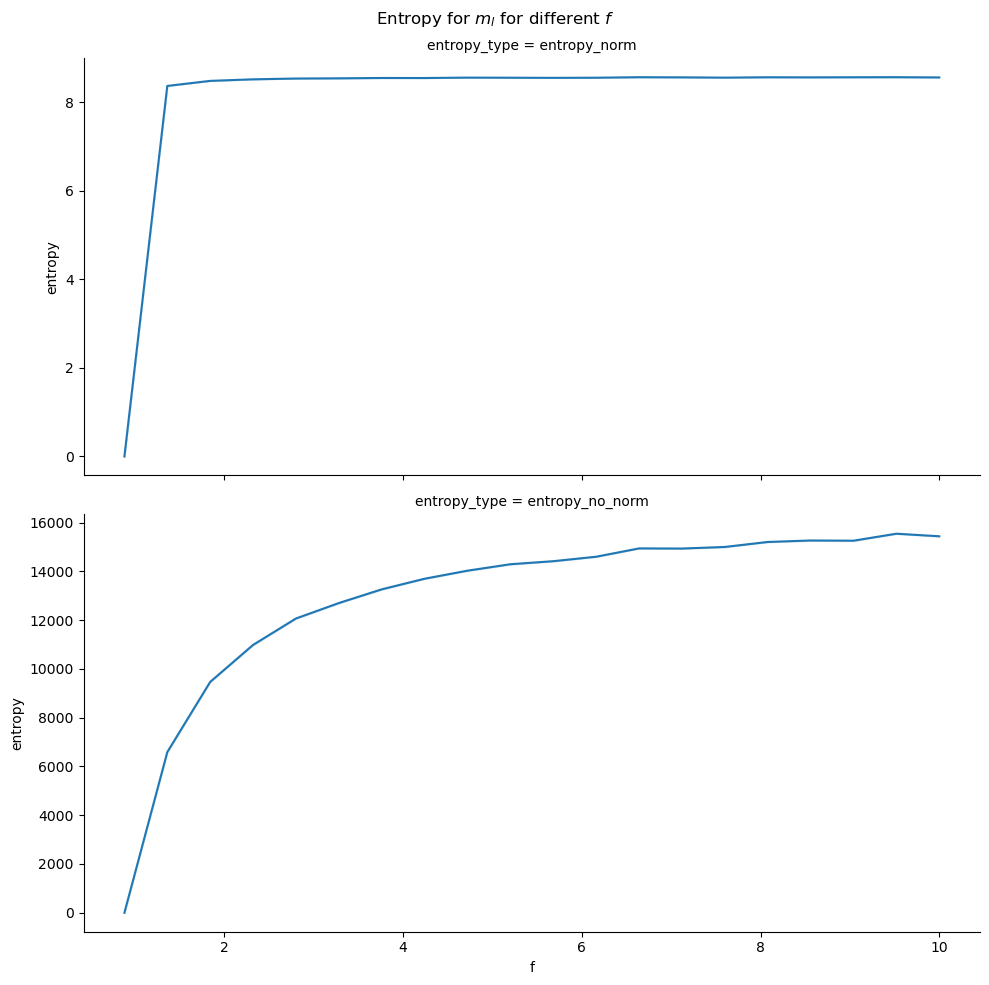

In [109]:
def make_long_df(entropy_res, f_range):
    df = pd.DataFrame(entropy_res.T)
    df.columns = f_range
    df = df.melt(var_name="f", value_name="entropy")
    return df


df_entropy = make_long_df(entropy_res, f_range)
df_entropy_no_norm = make_long_df(entropy_no_norm_res, f_range)

df_joined = df_entropy.merge(df_entropy_no_norm, on="f", suffixes=("_norm", "_no_norm"))
df_joined_melt = df_joined.melt(
    id_vars="f",
    value_vars=["entropy_norm", "entropy_no_norm"],
    var_name="entropy_type",
    value_name="entropy",
)

sns.relplot(
    df_joined_melt,
    x="f",
    y="entropy",
    kind="line",
    row="entropy_type",
    facet_kws={"sharey": False},
    aspect=2,
)
plt.suptitle("Entropy for $m_l$ for different $f$")
plt.tight_layout()

## Measure Entropy as function of Alpha and Gamma

In [302]:
# G = nx.karate_club_graph()
# G = nx.barabasi_albert_graph(100,4)
G = nx.erdos_renyi_graph(200, 0.1)
A = nx.adjacency_matrix(G, weight=None).todense()
n = np.size(A, axis=0)

x0 = np.ones(n)
# x0 = np.zeros(n)
# x0[random.randrange(n)] = 1

gamma0 = 0.1
nu = eigh(A)[0][-1]
b0 = 2 * gamma0 / nu
t0 = 100

sc = lambda nu, b: 1 - (1 - b) ** nu
c = sc(np.arange(n), b0)


gamma_range = np.linspace(0.01, 0.4, 10)
b_range = np.linspace(0.01, 0.4, 10)
n_iter = 1

entropy_res = np.zeros((len(gamma_range), len(b_range), n_iter))
entropy_no_norm_res = np.zeros((len(gamma_range), len(b_range), n_iter))

degree_c_i_entropy_res = np.zeros((len(gamma_range), len(b_range), n_iter))
degree_c_i_entropy_no_norm_res = np.zeros((len(gamma_range), len(b_range), n_iter))

results = dict()

for i, gamma_i in tqdm(enumerate(gamma_range)):
    for j, b_i in enumerate(b_range):

        t_i = gamma_i / gamma0 * t0

        for k in range(n_iter):

            c = sc(np.arange(n), b_i)
            x = contagion_process(A, gamma_i, c, x0, tmin=0, tmax=t_i)
            c_i, nu_i = count_all_infection_events(x, A)
            # c_list.append(c_i)
            degree_c_i_mat, _, _ = degree_infection_hist(A, c_i)

            entropy_res[i, j, k] = calc_entropy(c_i)
            entropy_no_norm_res[i, j, k] = calc_entropy(c_i, normalized=False)

            degree_c_i_entropy_res[i, j, k] = calc_entropy(degree_c_i_mat)
            degree_c_i_entropy_no_norm_res[i, j, k] = calc_entropy(
                degree_c_i_mat, normalized=False
            )

            results[f"{i}_{j}_{k}"] = x

0it [00:00, ?it/s]/var/folders/d8/_nh0kys17c383rmrhqbdm9y00000gn/T/ipykernel_85933/431954665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ci_degree_hist_cut.sort_values(by = 'degree',ascending = False,inplace = True)
/var/folders/d8/_nh0kys17c383rmrhqbdm9y00000gn/T/ipykernel_85933/431954665.py:21: RuntimeWarning: divide by zero encountered in divide
  p_1d = c_1d / np.sum(c_1d)#normalize the distribution
/var/folders/d8/_nh0kys17c383rmrhqbdm9y00000gn/T/ipykernel_85933/431954665.py:21: RuntimeWarning: invalid value encountered in divide
  p_1d = c_1d / np.sum(c_1d)#normalize the distribution
/var/folders/d8/_nh0kys17c383rmrhqbdm9y00000gn/T/ipykernel_85933/431954665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentat

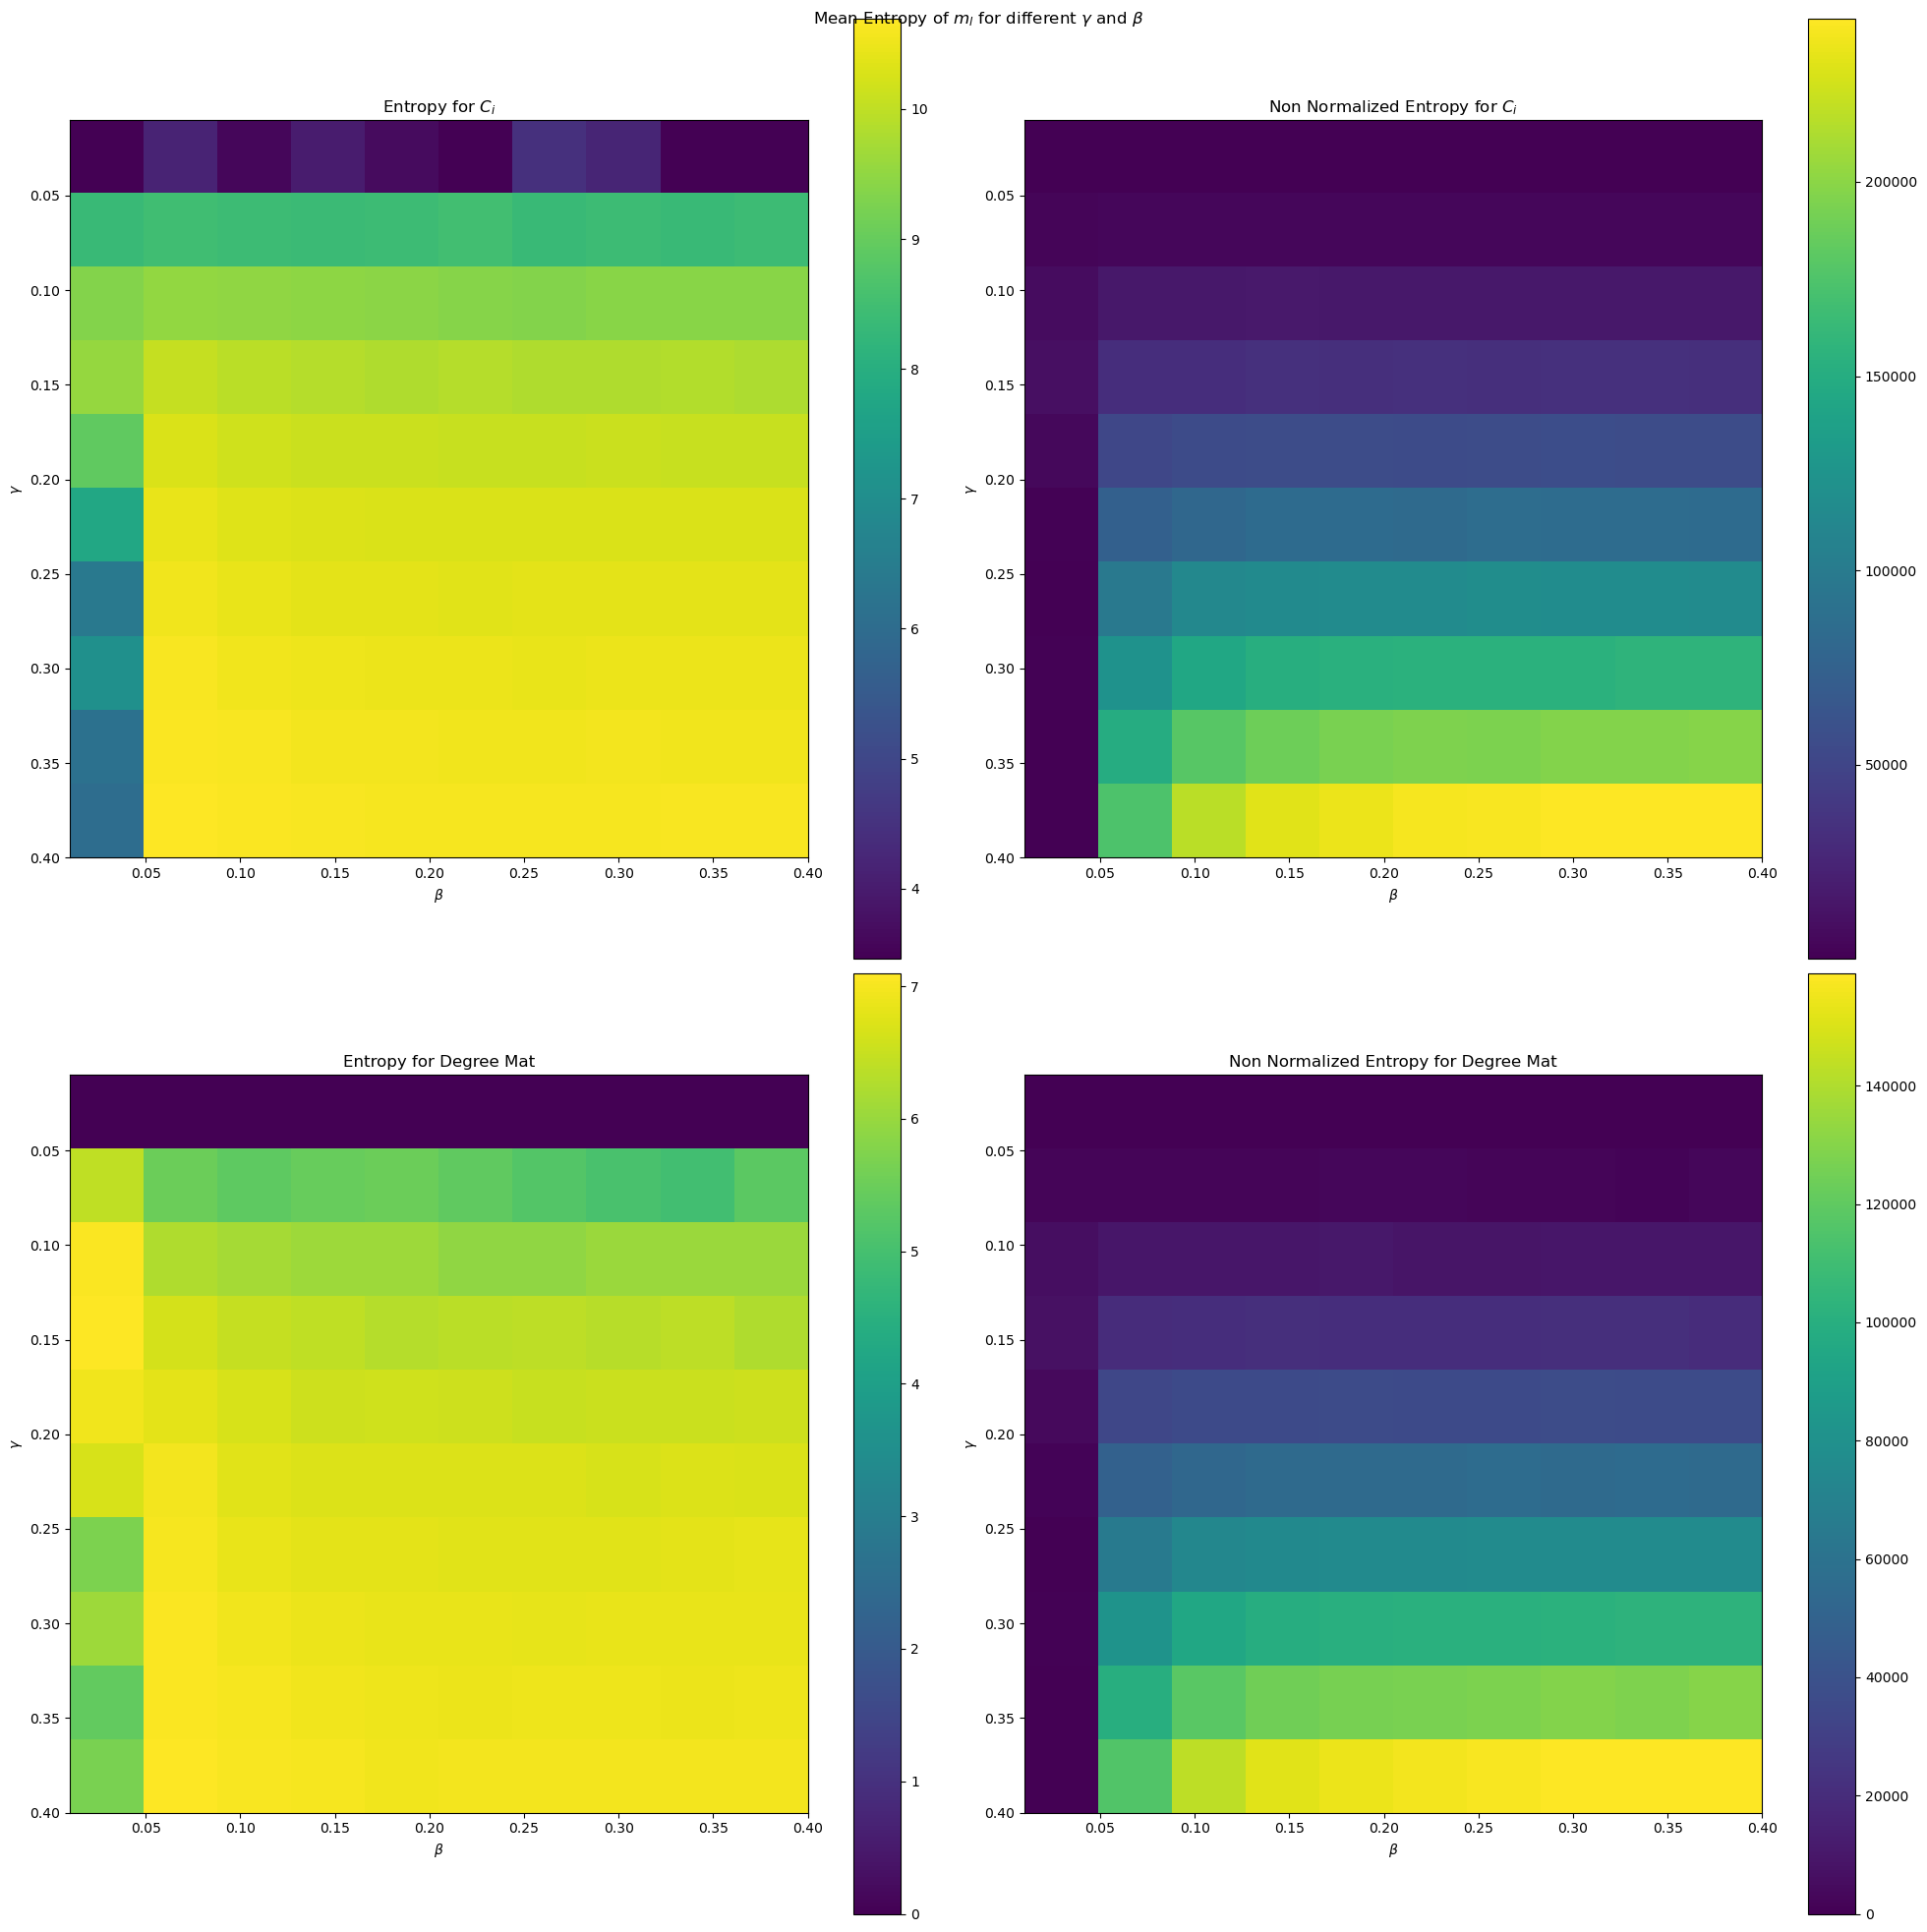

In [339]:
import matplotlib.ticker as ticker

mean_entropty = np.mean(entropy_res, axis=2)
mean_entropty_no_norm_res = np.mean(entropy_no_norm_res, axis=2)


degree_c_i_mean_entropty = np.mean(degree_c_i_entropy_res, axis=2)
degree_c_i_mean_entropty_no_norm_res = np.mean(degree_c_i_entropy_no_norm_res, axis=2)
# formatter = ticker.FuncFormatter(lambda x, pos: f'{x:.2f}')
formatter = ticker.FormatStrFormatter("%.2f")
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))

im1 = ax[0, 0].imshow(
    mean_entropty,
    extent=[min(b_range), max(b_range), max(gamma_range), min(gamma_range)],
)
ax[0, 0].set(ylabel=r"$\gamma$", xlabel=r"$\beta$", title="Entropy for $C_i$")
# ax[0,0].set_xticks(np.arange(len(b_range)))
# ax[0,0].set_xticklabels(b_range)
# ax[0,0].set_yticks(np.arange(len(gamma_range)))
# ax[0,0].set_yticklabels(gamma_range)
# ax[0,0].xaxis.set_major_formatter(formatter)
# ax[0,0].yaxis.set_major_formatter(formatter)
fig.colorbar(im1, ax=ax[0, 0])

im2 = ax[0, 1].imshow(
    mean_entropty_no_norm_res,
    extent=[min(b_range), max(b_range), max(gamma_range), min(gamma_range)],
)
ax[0, 1].set(
    ylabel=r"$\gamma$", xlabel=r"$\beta$", title="Non Normalized Entropy for $C_i$"
)
# ax[0,1].set_xticks(np.arange(len(b_range)))
# ax[0,1].set_xticklabels(b_range)
# ax[0,1].set_yticks(np.arange(len(gamma_range)))
# ax[0,1].set_yticklabels(gamma_range)
ax[0, 1].xaxis.set_major_formatter(formatter)
ax[0, 1].yaxis.set_major_formatter(formatter)
fig.colorbar(im2, ax=ax[0, 1])

im3 = ax[1, 0].imshow(
    degree_c_i_mean_entropty,
    extent=[min(b_range), max(b_range), max(gamma_range), min(gamma_range)],
)
ax[1, 0].set(ylabel=r"$\gamma$", xlabel=r"$\beta$", title="Entropy for Degree Mat")
# ax[1,0].set_xticks(np.arange(len(b_range)))
# ax[1,0].set_xticklabels(b_range)
# ax[1,0].set_yticks(np.arange(len(gamma_range)))
# ax[1,0].set_yticklabels(gamma_range)
ax[1, 0].xaxis.set_major_formatter(formatter)
ax[1, 0].yaxis.set_major_formatter(formatter)
fig.colorbar(im3, ax=ax[1, 0])

im4 = ax[1, 1].imshow(
    degree_c_i_mean_entropty_no_norm_res,
    extent=[min(b_range), max(b_range), max(gamma_range), min(gamma_range)],
)
ax[1, 1].set(
    ylabel=r"$\gamma$", xlabel=r"$\beta$", title="Non Normalized Entropy for Degree Mat"
)
# ax[1,1].set_xticks(np.arange(len(b_range)))
# ax[1,1].set_xticklabels(b_range)
# ax[1,1].set_yticks(np.arange(len(gamma_range)))
# ax[1,1].set_yticklabels(gamma_range)
ax[1, 1].xaxis.set_major_formatter(formatter)
ax[1, 1].yaxis.set_major_formatter(formatter)
fig.colorbar(im4, ax=ax[1, 1])

# Add a single colorbar for all subplots
# fig.colorbar(im, ax=ax.ravel().tolist())

plt.suptitle(r"Mean Entropy of $m_l$ for different $\gamma$ and $\beta$")
plt.tight_layout()
plt.savefig("")

## What do the distributions look like

/var/folders/d8/_nh0kys17c383rmrhqbdm9y00000gn/T/ipykernel_85933/431954665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ci_degree_hist_cut.sort_values(by = 'degree',ascending = False,inplace = True)


Text(0.5, 0.98, 'Gamma Index: 0.3566666666666667, Beta Index: 0.01')

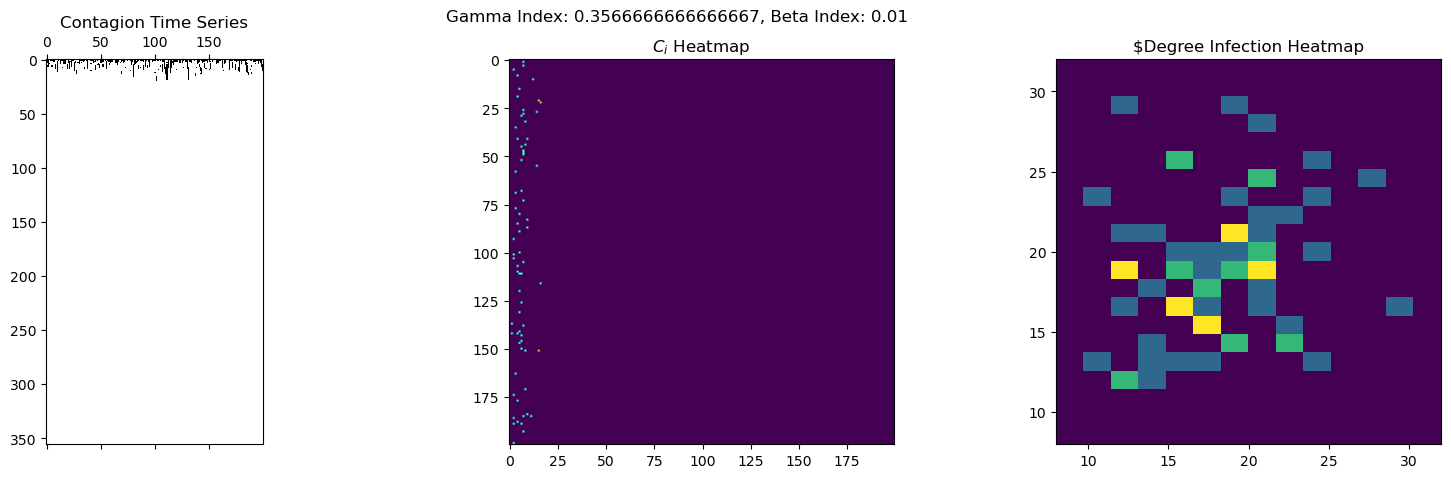

In [370]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))


gamma_index = 8
beta_index = 0

key = f"{gamma_index}_{beta_index}_0"
x_key = results[key]
c_i, _ = count_all_infection_events(x_key, A)
degree_infection_hist_mat, degree_list, infection_count = degree_infection_hist(A, c_i)
ax[0].spy(x_key)
ax[1].imshow(c_i)
ax[2].imshow(
    degree_infection_hist_mat,
    extent=[degree_list.min(), degree_list.max(), degree_list.min(), degree_list.max()],
)

ax[0].set(title="Contagion Time Series")
ax[1].set(title="$C_i$ Heatmap")
ax[2].set(title="$Degree Infection Heatmap")
plt.suptitle(
    "Gamma Index: {}, Beta Index: {}".format(
        gamma_range[gamma_index], b_range[beta_index]
    )
)

In [364]:
gamma_index = 2
beta_index = 8

key = f"{gamma_index}_{beta_index}_0"
x_key = results[key]
c_i, _ = count_all_infection_events(x_key, A)
degree_infection_hist_mat, degree_list, infection_count = degree_infection_hist(A, c_i)
ax[0].spy(x_key)
ax[1].imshow(c_i)
ax[2].imshow(
    degree_infection_hist_mat,
    extent=[degree_list.min(), degree_list.max(), degree_list.min(), degree_list.max()],
)

ax[0].set(title="Contagion Time Series")
ax[1].set(title="$C_i$ Heatmap")
ax[2].set(title="$Degree Infection Heatmap")
plt.suptitle(
    "Gamma Index: {}, Beta Index: {}".format(
        gamma_range[gamma_index], b_range[beta_index]
    )
)

/var/folders/d8/_nh0kys17c383rmrhqbdm9y00000gn/T/ipykernel_85933/431954665.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ci_degree_hist_cut.sort_values(by = 'degree',ascending = False,inplace = True)


Text(0.5, 0.98, 'Gamma Index: 0.09666666666666666, Beta Index: 0.3566666666666667')

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Degree Distribution')

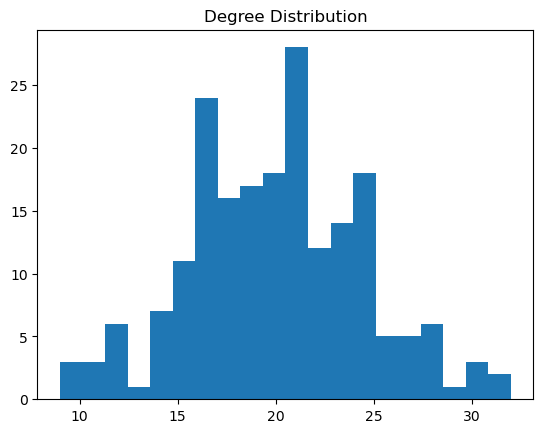

In [218]:
plt.hist(degree_mat, bins=20)
plt.title("Degree Distribution")